In [57]:
import pandas as pd
from scipy.stats import wilcoxon
import numpy as np
import math
import matplotlib.pyplot as plt
from pingouin import plot_paired
import seaborn as sns

In [59]:
pd.options.display.float_format = '{:,.2f}'.format

Read the data for LGBM models built using the default parameters.

In [2]:
df_def = pd.read_csv("benchmark_default.csv")
df_def.columns = ["cycle","r2_trad_def","r2_delta_def","rmse_trad_def","rmse_delta_def","dataset"]

In [3]:
df_def.head()

,cycle,r2_trad_def,r2_delta_def,rmse_trad_def,rmse_delta_def,dataset
0,0,0.724192,0.709159,0.598822,0.614924,Caco2
1,1,0.639276,0.688327,0.610653,0.567619,Caco2
2,2,0.634976,0.640841,0.632504,0.627402,Caco2
3,3,0.725073,0.769266,0.626732,0.574155,Caco2
4,4,0.697223,0.706401,0.642885,0.633066,Caco2


Read the data for LGBM models built using **subsample=0.1, subsample_freq = 1**

In [4]:
df_sub = pd.read_csv("benchmark_subsamp.csv")
df_sub.columns = ["cycle","r2_trad_sub","r2_delta_sub","rmse_trad_sub","rmse_delta_sub","dataset"]

In [5]:
df_sub.head()

,cycle,r2_trad_sub,r2_delta_sub,rmse_trad_sub,rmse_delta_sub,dataset
0,0,0.402085,0.689293,0.881685,0.635579,Caco2
1,1,0.290319,0.649673,0.856522,0.601788,Caco2
2,2,0.319385,0.656183,0.863680,0.613855,Caco2
3,3,0.412020,0.756006,0.916547,0.590423,Caco2
4,4,0.277422,0.713865,0.993149,0.624968,Caco2


Merge the two datasets

In [6]:
combo_df = df_def.merge(df_sub,on=["dataset","cycle"])
cols = ['dataset','cycle', 'r2_trad_def', 'r2_delta_def', 'r2_trad_sub', 'r2_delta_sub',
        'rmse_trad_def', 'rmse_delta_def', 'rmse_trad_sub', 'rmse_delta_sub']
combo_df = combo_df[cols]

Drop FUBrain since it's small

In [7]:
combo_df = combo_df.query("dataset != 'FUBrain'")

In [8]:
combo_df.head()

,dataset,cycle,r2_trad_def,r2_delta_def,r2_trad_sub,r2_delta_sub,rmse_trad_def,rmse_delta_def,rmse_trad_sub,rmse_delta_sub
0,Caco2,0,0.724192,0.709159,0.402085,0.689293,0.598822,0.614924,0.881685,0.635579
1,Caco2,1,0.639276,0.688327,0.290319,0.649673,0.610653,0.567619,0.856522,0.601788
2,Caco2,2,0.634976,0.640841,0.319385,0.656183,0.632504,0.627402,0.863680,0.613855
3,Caco2,3,0.725073,0.769266,0.412020,0.756006,0.626732,0.574155,0.916547,0.590423
4,Caco2,4,0.697223,0.706401,0.277422,0.713865,0.642885,0.633066,0.993149,0.624968


Define a function to calculate mean values, Cohen's D and the associated probability, and a Wilcoxon statistic.

In [9]:
def compare_sets(df_in, col_1, col_2):
    res = []
    for k,v in df_in.groupby("dataset"):
        diff = v[col_1]-v[col_2]
        score,p_val = wilcoxon(v[col_1], v[col_2])
        d = np.mean(diff)/np.std(diff)
        prob = 0.25 * abs(d) + 0.5
        res.append([k,v[col_1].mean(),v[col_2].mean(),d, prob,p_val])
    res_df = pd.DataFrame(res,columns=["Dataset",col_1,col_2,"Cohen's D","Probability","Wilcoxon p"])
    return res_df

Define a function to plot pairs comparing two methods.  

In [53]:
def plot_datasets(result_df, column_list, out_column, y_axis_label):
    ncols = 4
    num_datasets = len(result_df.dataset.unique())
    nrows = math.ceil(num_datasets/ncols)
    # reshape the data
    melt_df = pd.melt(result_df[["cycle","dataset"]+column_list],id_vars=["cycle","dataset"])
    melt_df.columns = ["cycle","dataset","method"]+[out_column]

    # setup the plot grid
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
    axes = axes.flatten()
    for idx, (name, ax_id) in enumerate(zip(result_df.dataset.unique(), axes)):
        col = idx % ncols
        row = idx // ncols
        ax = plot_paired(data=melt_df.query("dataset == @name"), dv=out_column, within="method", subject="cycle",
                         ax=ax_id,boxplot=False)
        ax.set_title(f"{name}")
        ax.set_xlabel("")
        #ax.set_xticklabels(["Delta","Traditional"])
        ax.set_ylabel(y_axis_label)
    plt.tight_layout()

Compare the traditional LGBM and delta LGBM with **subsample=0.1, subsample_freq = 1** for both methods. 

In [62]:
compare_sets(combo_df,"r2_trad_sub","r2_delta_sub")

,Dataset,r2_trad_sub,r2_delta_sub,Cohen's D,Probability,Wilcoxon p
0,Caco2,0.33,0.68,-4.30,1.58,0.00
1,FreeSolv,0.35,0.80,-5.44,1.86,0.00
2,HemoTox,0.49,0.66,-2.12,1.03,0.00
3,HepClear,0.08,0.14,-0.68,0.67,0.00
4,MicroClear,0.07,0.16,-0.94,0.73,0.00
5,RenClear,0.09,0.18,-0.88,0.72,0.00
6,Sol,0.35,0.72,-6.04,2.01,0.00
7,VDss,0.34,0.51,-2.98,1.25,0.00


Plot delta LGBM with subsample=0.1, subsample_freq = 1 vs traditional LGBM with subsample=0.1, subsample_freq = 1

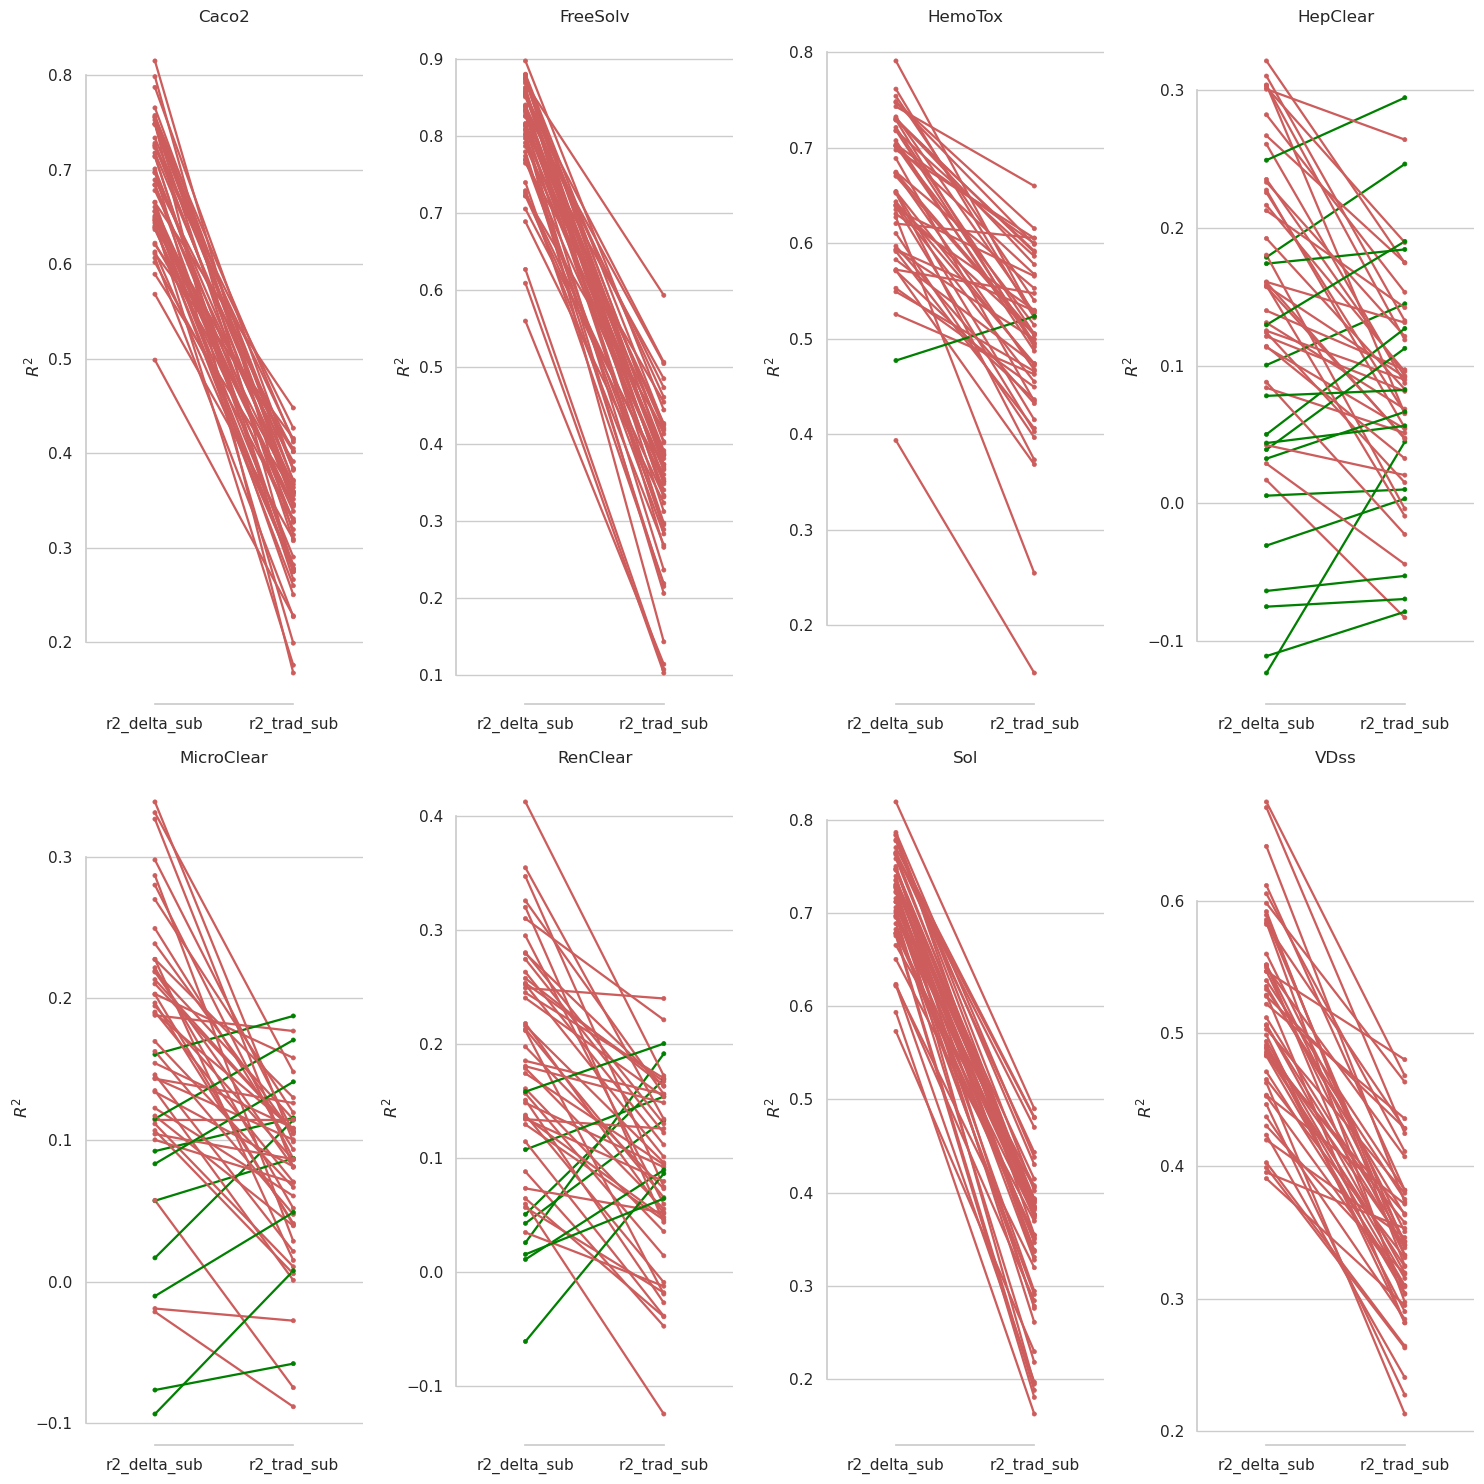

In [66]:
sns.set_style('whitegrid')
sns.set_context('notebook')
plot_datasets(combo_df,["r2_trad_sub","r2_delta_sub"],"r2","$R^2$")

Compare delta LGBM with subsample=0.1, subsample_freq = 1 to traditional LGBM with default parameters 

In [63]:
compare_sets(combo_df,"r2_trad_def","r2_delta_sub")

,Dataset,r2_trad_def,r2_delta_sub,Cohen's D,Probability,Wilcoxon p
0,Caco2,0.68,0.68,-0.08,0.52,0.55
1,FreeSolv,0.69,0.80,-1.57,0.89,0.00
2,HemoTox,0.68,0.66,0.69,0.67,0.00
3,HepClear,0.12,0.14,-0.40,0.60,0.01
4,MicroClear,0.13,0.16,-0.29,0.57,0.07
5,RenClear,0.17,0.18,-0.07,0.52,0.61
6,Sol,0.72,0.72,0.02,0.51,0.89
7,VDss,0.53,0.51,0.38,0.60,0.01


Plot delta LGBM with subsample=0.1, subsample_freq = 1 vs traditional LGBM with default parameters

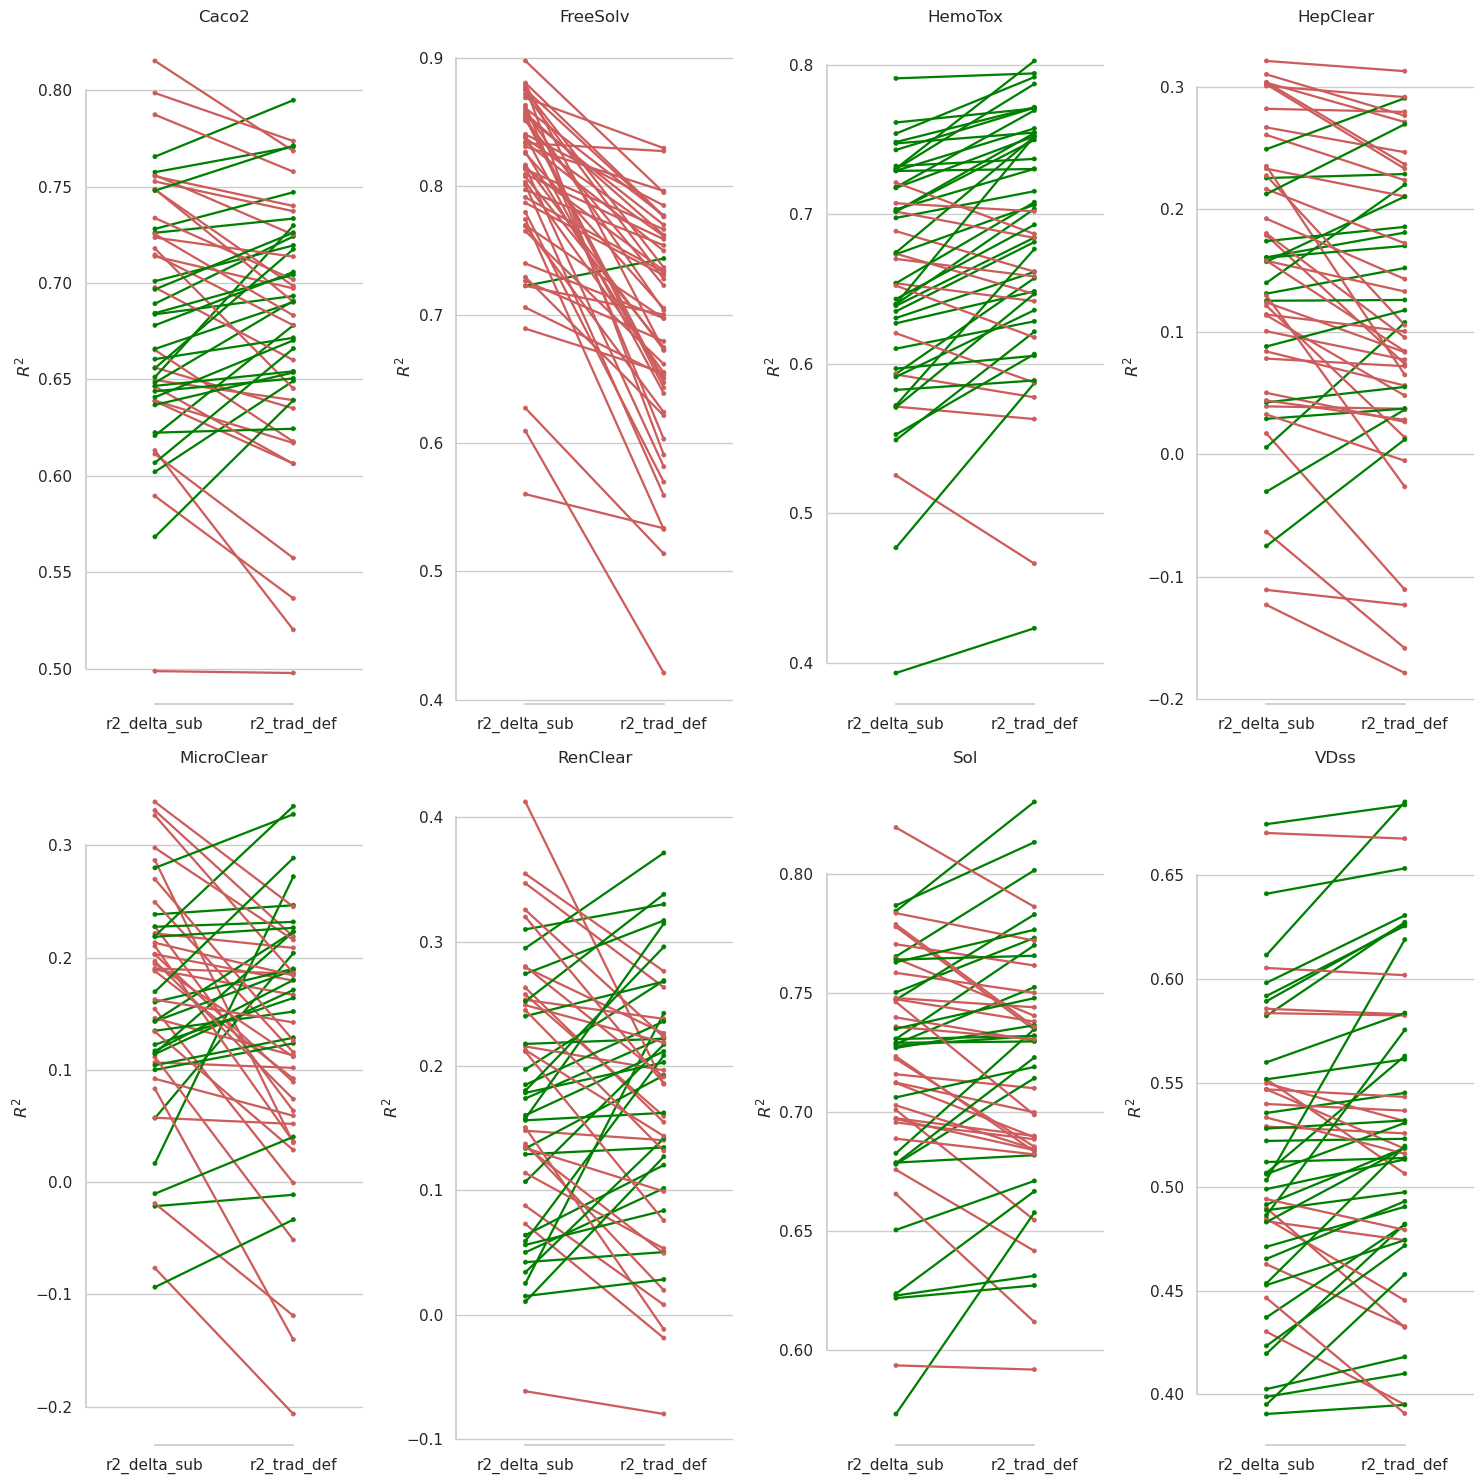

In [65]:
sns.set_style('whitegrid')
sns.set_context('notebook')
plot_datasets(combo_df,["r2_trad_def","r2_delta_sub"],"r2","$R^2$")

Compare delta LGBM with default parameters to traditional LGBM with default parameters

In [67]:
compare_sets(combo_df,"r2_trad_def","r2_delta_def")

,Dataset,r2_trad_def,r2_delta_def,Cohen's D,Probability,Wilcoxon p
0,Caco2,0.68,0.68,-0.13,0.53,0.32
1,FreeSolv,0.69,0.80,-1.49,0.87,0.00
2,HemoTox,0.68,0.66,0.65,0.66,0.00
3,HepClear,0.12,0.14,-0.43,0.61,0.00
4,MicroClear,0.13,0.16,-0.33,0.58,0.04
5,RenClear,0.17,0.17,-0.01,0.50,0.84
6,Sol,0.72,0.72,-0.05,0.51,0.37
7,VDss,0.53,0.51,0.50,0.62,0.00


Plot delta LGBM with default parameters vs traditional LGBM with default parameters

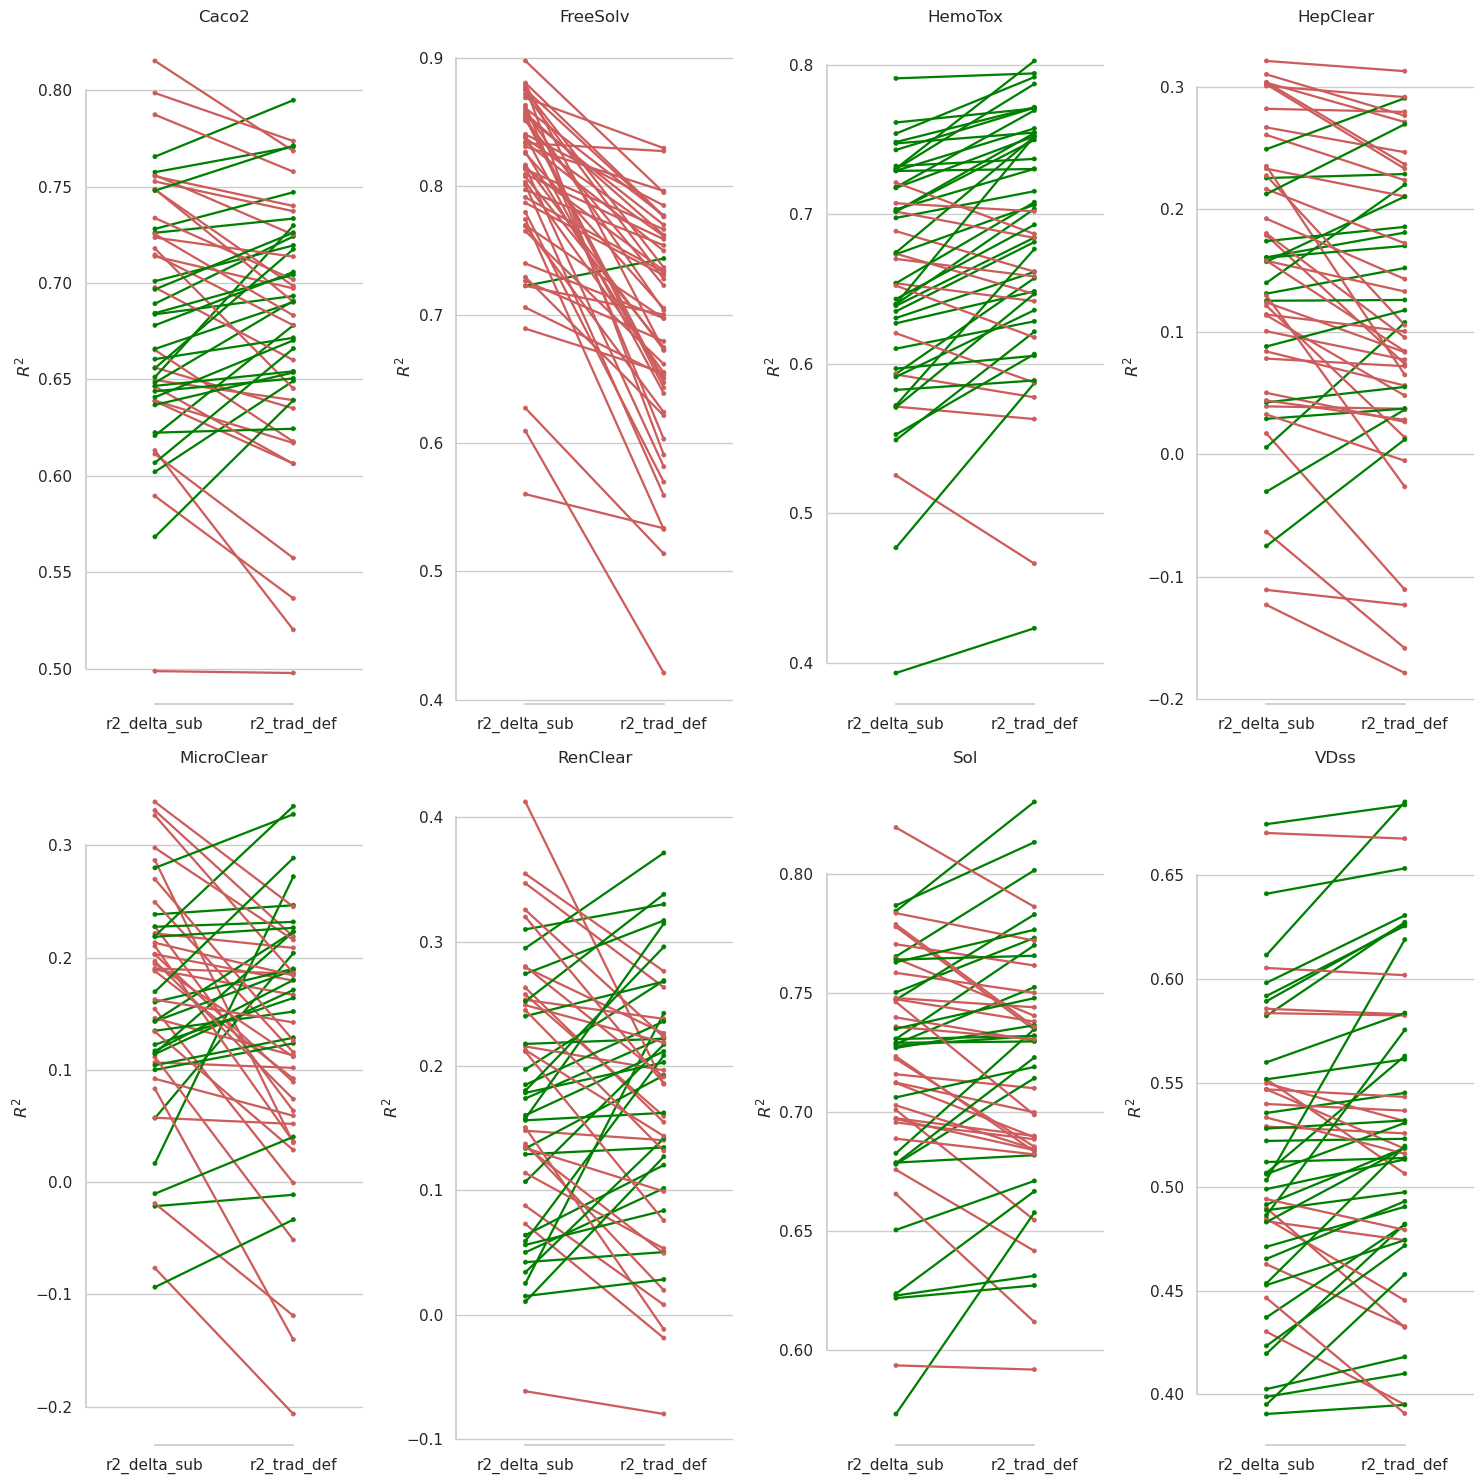

In [68]:
sns.set_style('whitegrid')
sns.set_context('notebook')
plot_datasets(combo_df,["r2_trad_def","r2_delta_sub"],"r2","$R^2$")